# Auswertung

In [1]:
#Benötigte Pakete
%matplotlib inline 
import numpy as np
import io
import csv
from decimal import Decimal
import matplotlib.pyplot as plt
from scipy import odr
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.stats import chi2
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = 16, 9

In [2]:
def sig(val1,err1,val2,err2):
    sig = np.abs(val2-val1)**2/np.abs(np.abs(err2)+np.abs(err1))**2
    return round(sig,3)

def form(val,err): #form function for prints
        a = "{value:4.3f} ± {error:4.3f}".format(value=val,error=err)
        return a
def format_e(n):
    a = '%e' % Decimal(n)
    return a.split('e')[0].rstrip('0').rstrip('.')+'e'+a.split('e')[1]
def read_csv(filename):
    data = np.genfromtxt(filename,delimiter=',')
    Data = np.transpose(data)
    return Data
def read_jdx(filename):
    x, I1 , I2, I3, I4, I5, I6, I7, I8 = np.loadtxt(filename,
                                                    skiprows=20,
                                                    usecols=(0, 1, 2, 3, 4, 5, 6, 7, 8),
                                                    unpack=True,encoding='latin-1')
    I = []
    for k in range(0,len(x),1):
        I.append(I1[k])
        I.append(I2[k])
        I.append(I3[k])
        I.append(I4[k])
        I.append(I5[k])
        I.append(I6[k])
        I.append(I7[k])
        I.append(I8[k])
    I = np.array(I)
    x = np.arange(1,I.size+1)
    return x,I

def fitgüte(x,y,delta_x,delta_y,popt,fit_funktion):    
    chisquare=np.sum((fit_funktion(popt, x)-y)**2/
                     (delta_y**2+((fit_func(popt, x+delta_x)-fit_func(popt, x-delta_x))/2)**2))

    #Freiheitsgrade
    dof=dof = x.size-popt.size
    if dof == 0:
        chisquare_red = 'inf'
        prob = 100
    else:
        chisquare_red = chisquare/dof
        prob = round(1-chi2.cdf(chisquare,dof),3)*100 #Fitwahrscheinlichket

    print('chi_squared= ' + str(chisquare))#format_e(chisquare))
    print('chi_squared_red= ' + str(chisquare_red))#format_e(chisquare_red))
    print('Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: ' +
          str(prob) + ' %')

## Teil 1: Quantitative Beobachtungen am Einzelspalt

Ziel ist der Vergleich der hier gemessenen Maxima und Minima, sowie die Intensitätsverhältnisse mit den theoretischen Werten. Dazu soll vorerst die Spaltbreite $d$ des verwendeten Beugungsspaltes (Einzelspalt B) bestimmt werden.
Da die CCD-Kamera allerdings nur in Pixel misst, muss erst einmal ein Umrechnungsfaktor von Pixel zu Metern errechnet werden. 

### Beugungsbild des Einzelspaltes

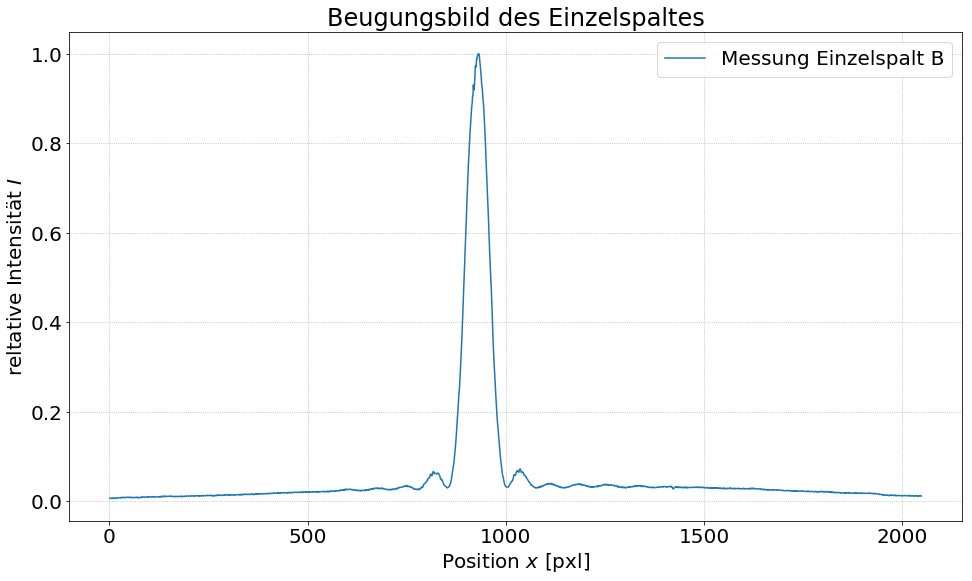

In [3]:
def Plot(filename,lab):
    x_es, I_es = read_jdx(filename)
    I_es = I_es/max(I_es)

    plt.plot(x_es,I_es, label=lab)
Plot('Data/A1 Einzelspalt B komplett.jdx','Messung Einzelspalt B')
plt.title('Beugungsbild des Einzelspaltes')
plt.grid(ls=':')
plt.xlabel('Position $x$ [pxl]')
plt.ylabel('reltative Intensität $I$')
plt.legend(loc='best')
plt.show()

### Eichung

In [4]:
#Eichung der Pixelskala zum Umrechnen des Spaltabstands in Längeneinheiten 
dpx=read_csv('Data/A1 Eichung.csv')[0]
dpx_err=3*np.ones(dpx.size)
slit_aperture=read_csv('Data/A1 Eichung.csv')[1]*2 # Messwerte verdoppelt
slit_aperture_err=0.02*np.ones(4)

gauge=slit_aperture/dpx  #Faktor zur Umrechnung von Pixel in mm

gauge_mean=np.mean(gauge)
gauge_syst=np.mean(gauge*np.sqrt((slit_aperture_err/slit_aperture)**2+(dpx_err/dpx)**2))
gauge_stat=np.std(gauge)/np.sqrt(4)


print('\nUmrechnungsfaktor:\n ')
print('u = ',format_e(gauge_mean), ' ± ' ,format_e(gauge_syst+gauge_stat))


Umrechnungsfaktor:
 
u =  1.285808e-03  ±  2.953028e-04


### Bestimmung der Spaltbreite

In [5]:
#Bestimmung der Abstände der Minima 
n_min_einzelspalt = np.array([1.0,2.0,3.0,4.0,5.0])
dn_min_einzelspalt = np.full(n_min_einzelspalt.size,1e-6)
x_min_einzelspalt = read_csv('Data/A1 Einzelspalt B_minima.csv')[0] 
dx_min_einzelspalt = np.full(x_min_einzelspalt.size,3)

#Bestimmung der Abstände der Maxima
x_max_einzelspalt = read_csv('Data/A1 Einzelspalt B_peaks2.csv')[0]
dx_max_einzelspalt = np.full(x_max_einzelspalt.size,3)


Fitgüte Minima:

chi_squared= 9.95555554976026
chi_squared_red= 3.3185185165867535
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 1.9 %



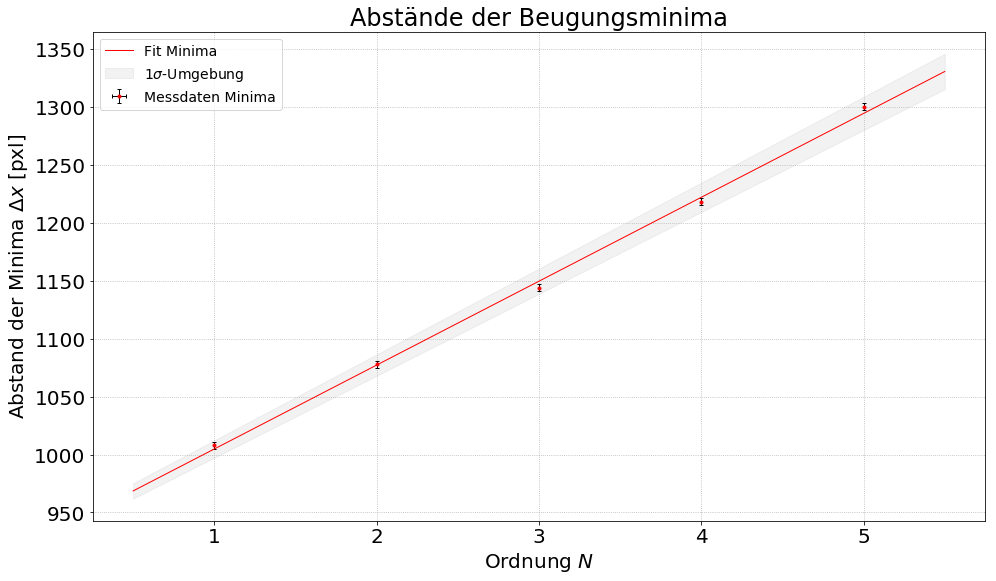

Die Steigung der Fit-Gerade beträgt:
s =  72.400 ± 1.728  [pxl]
Mit y-Achsenabschnitt:
c =  932.400 ± 5.732  [pxl]


In [6]:
#Fitfunktion
def fit_func(p, x):
        (s,a) = p 
        return s*x+a

def fit(x,dx,y,dy,c,name,para0,fit_func,plt_range):
    
    from scipy import odr
    model = odr.Model(fit_func)
    
    x = x
    y = y
    delta_x = dx
    delta_y = dy
    
    #Startparameter
    para0 = para0
    
    data = odr.RealData(x, y, sx=delta_x, sy=delta_y)
    odr = odr.ODR(data, model, beta0=para0)
    out = odr.run()

    #1-Sigma
    popt = out.beta
    perr = out.sd_beta

    #Sigma-Umgebung
    nstd = 1 # um n-Sigma-Umgebung im Diagramm zu zeichnen

    popt_top = popt+nstd*perr
    popt_bot = popt-nstd*perr

    #Plot-Umgebung
    x_fit = np.linspace(min(x)-plt_range, max(x)+plt_range, 1000)
    fit = fit_func(popt, x_fit)
    fit_top = fit_func(popt_top, x_fit)
    fit_bot = fit_func(popt_bot, x_fit)

    plt.errorbar(x, y, xerr=delta_x, yerr=delta_y, lw=1, ecolor='k', mec=c, 
                 mfc=c, fmt='.', capsize=2,
                 label='Messdaten '+name)
    plt.plot(x_fit, fit, color=c, lw=1, label='Fit '+name)
    plt.fill_between(x_fit, fit_top, fit_bot, color='k', alpha=.05, 
                     label=str(nstd)+r'$\sigma$'+'-Umgebung')
    print('\nFitgüte '+ name+ ':\n')
    fitgüte(x,y,delta_x,delta_y,popt,fit_func) #[:-3] 
    print('')
    return popt, perr

popt, perr = fit(n_min_einzelspalt,dn_min_einzelspalt,
                 x_min_einzelspalt,dx_min_einzelspalt,
                  'r','Minima',[1,1],fit_func,0.5)

plt.title('Abstände der Beugungsminima')
plt.grid(ls=':')
plt.xlabel('Ordnung $N$')
plt.ylabel('Abstand der Minima $\Delta x$ [pxl]')
plt.legend(loc='best',fontsize=14)
plt.show()

#Auswertung
eta_mean = popt[0]
deta_mean = perr[0]

#Ausgabe
a=popt[0]
a_err=perr[0]

print('Die Steigung der Fit-Gerade beträgt:')
print('s = ', form(a,a_err), ' [pxl]')
print('Mit y-Achsenabschnitt:')
print('c = ', form(popt[1],perr[1]),' [pxl]')

In [7]:
#Umrechnung der Spaltbreite in mm
a_prime= gauge_mean*a

a_prime_syst=np.sqrt((gauge_syst)**2+(a_err*gauge_mean)**2)
a_prime_stat=np.sqrt((gauge_stat)**2+(a_err*gauge_mean)**2)

a_prime_mean=np.mean(a_prime)
a_prime_mean_syst=np.sqrt((gauge_mean*perr[0]**0.5)**2+(popt[0]*gauge_syst)**2)
a_prime_mean_stat=np.sqrt((gauge_mean*perr[0]**0.5)**2+(popt[0]*gauge_stat)**2)

print('Mit der Eichung der Skala erhalten wir die Steigung a_prime:')
print( 'a_prime = ', form(a_prime_mean,a_prime_mean_syst+a_prime_mean_stat), ' [mm/order]')

Mit der Eichung der Skala erhalten wir die Steigung a_prime:
a_prime =  0.093 ± 0.022  [mm/order]


In [8]:
#Bestimmung der Spaltbreite aus der Steigung des Fits (Herleitung in Auswertung)
wavelength=635e-9
f1= 80e-3 

b=2*wavelength*f1/(a_prime_mean*1e-3)
b_syst=b*(a_prime_mean_syst/a_prime_mean)
b_stat=b*(a_prime_mean_stat/a_prime_mean)

print('Aus der Steigung erhalten wir:')
print('b = ',form(b*1e3,b_syst+b_stat*1e3), ' mm')

Aus der Steigung erhalten wir:
b =  1.091 ± 0.234  mm


### Bestimmung der Maxima 


Fitgüte Minima:

chi_squared= 9.95555554976026
chi_squared_red= 3.3185185165867535
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 1.9 %



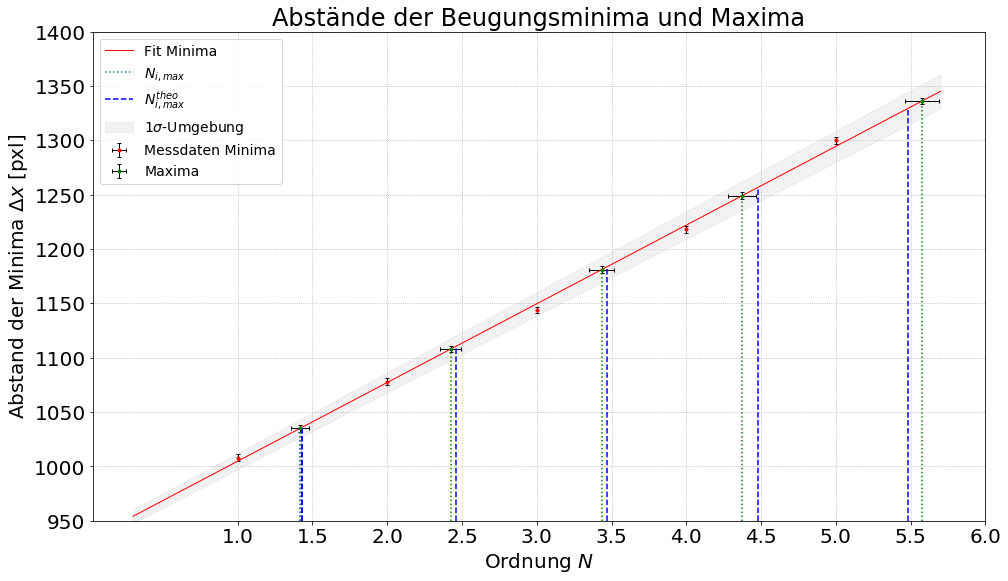

In [9]:
popt, perr = fit(n_min_einzelspalt,dn_min_einzelspalt,
                 x_min_einzelspalt,dx_min_einzelspalt,
                  'r','Minima',[1,1],fit_func,0.7)

def fit_func_umkehr(p, x):
        (s,a) = p 
        return (x-a)/s

n_max_einzelspalt = fit_func_umkehr(popt,x_max_einzelspalt)
dn_max_einzelspalt = np.sqrt((dx_max_einzelspalt/popt[0])**2+
                                   (perr[1]**0.5/popt[0])**2+
                                   ((x_max_einzelspalt-popt[1])*perr[0]**0.5/popt[0]**2)**2)

plt.errorbar(n_max_einzelspalt, x_max_einzelspalt, 
             xerr=dn_max_einzelspalt, yerr=dx_max_einzelspalt,
             lw=1, ecolor='k', mec='g', mfc='g', fmt='.', capsize=2,label='Maxima')

def n_max_num(n):
    q = (n+1/2)*np.pi
    n_max = q - q**-1 - 2/3*q**-3 - 13/15*q**-5 - 146/105*q**-7
    # https://en.wikipedia.org/wiki/Sinc_function
    return n_max/np.pi

n_max_opt = n_max_num(np.arange(1,6))
n_max_opt

for i in range(len(n_max_einzelspalt)): 
    n = n_max_einzelspalt[i]
    b = n_max_opt[i]
    dn = dn_max_einzelspalt[i]
    plt.axvline(n,ymin=0,ymax=(x_max_einzelspalt[i]-950)/(1400-950),ls=':',c='g')
    plt.axvline(b,ymin=0,ymax=(fit_func(popt,b)-950)/(1400-950),ls='--',c='b')
    
plt.axvline(n_max_einzelspalt[0],ymin=0,ymax=(x_max_einzelspalt[0]-950)/(1400-950),ls=':',
            label='$N_{i,max}$')
plt.axvline(n_max_opt[0],ymin=0,ymax=(fit_func(popt,n_max_opt[0])-950)/(1400-950),ls='--',
            c='b',label='$N_{i,max}^{theo}$')
plt.ylim([950,1400])
plt.title('Abstände der Beugungsminima und Maxima')
plt.grid(ls=':')
plt.xticks(np.arange(1,6.5,0.5))
plt.xlabel('Ordnung $N$')
plt.ylabel('Abstand der Minima $\Delta x$ [pxl]')
plt.legend(loc='best',fontsize=14)
plt.show()

### Fehlerabschätzung der Beugungsordnung der Maxima

In [10]:
print('\nBeugungsordnung der Maxima:\n')
for i in range(len(n_max_einzelspalt)):
    n = n_max_einzelspalt[i]
    dn = dn_max_einzelspalt[i]
    sigma = sig(n,dn,n_max_opt[i],0)
    print('N_%d ='%(i+1), form(n,dn))
    print('N_%d_theo ='%(i+1), round(n_max_opt[i],3))
    print('sigma = ',sigma, '\n')


Beugungsordnung der Maxima:

N_1 = 1.417 ± 0.059
N_1_theo = 1.43
sigma =  0.05 

N_2 = 2.425 ± 0.069
N_2_theo = 2.459
sigma =  0.238 

N_3 = 3.434 ± 0.082
N_3_theo = 3.471
sigma =  0.206 

N_4 = 4.373 ± 0.095
N_4_theo = 4.477
sigma =  1.198 

N_5 = 5.575 ± 0.114
N_5_theo = 5.482
sigma =  0.663 



| $N_\text{max}^\text{theo}$ | $N_\text{max}^\text{mes}$ | $\sigma$-Abw. |
|---|---|---|
| 1.430 | 1.417 $\pm$ 0.059 | 0.05 |
| 2.459 | 2.425 $\pm$ 0.069 | 0.24 |
| 3.471 | 3.434 $\pm$ 0.082 | 0.20 |
| 4.477 | 4.373 $\pm$ 0.095 | 1.20 |
| 5.482 | 5.575 $\pm$ 0.114 | 0.66 |

### Vergleich der relativen Intensitäten

#### Messwerte

In [11]:
def read_csv_rel(filename):
    x = read_csv(filename)[0]
    dx = np.full(x.size,3)
    I = read_csv(filename)[1]
    I = I/max(I)
    dI = I*0.05
    return x, dx, I, dI

x_max1, dx_max1, I_max1, dI_max1 = read_csv_rel('Data/A1 Einzelspalt B_peaks1.csv')
x_max2, dx_max2, I_max2, dI_max2 = read_csv_rel('Data/A1 Einzelspalt B_peaks2.csv')

x_max = np.append(x_max1[:-1], x_max2)
dx_max = np.append(dx_max1[:-1], dx_max2)
I_max = np.append(I_max1[:-1], I_max2*min(I_max1))
dI_max = np.append(dI_max1[:-1], dI_max2)

#### Theoretische relative Intensität

In [12]:
def beugung_spalt(x):
    return np.sinc(x)**2

# kleinere Schrittweite für präzisere Berechnung der Maxima, 
# ungerade Anzahl damit nur einmal das nullte berechnet wird
a=5
x=np.linspace(-(a+1),a+1,200001)

#Berechnung der relativen Maxima
slit_theory=argrelextrema(beugung_spalt(x), np.greater_equal, order = 1) 
max_theory=np.array(beugung_spalt(x[slit_theory]))
max_theory_sliced=max_theory[4::-1]

In [13]:
print('\nRelative Intensitäten der Maxima:\n')
for i in range(0,len(I_max)-1):
    print('I_%d/I_0_mes  ='%(i+1), format_e(I_max[i+1]), ' ± ', format_e(dI_max[i+1]))   
    print('I_%d/I_0_theo ='%(i+1),format_e(max_theory_sliced[i]))
    print('sigma =', sig(I_max[i+1],dI_max[i+1],max_theory_sliced[i],0),'\n')


Relative Intensitäten der Maxima:

I_1/I_0_mes  = 7.329278e-02  ±  5e-02
I_1/I_0_theo = 4.719045e-02
sigma = 0.273 

I_2/I_0_mes  = 1.95472e-02  ±  1.333501e-02
I_2/I_0_theo = 1.648003e-02
sigma = 0.053 

I_3/I_0_mes  = 1.675408e-02  ±  1.142956e-02
I_3/I_0_theo = 8.340293e-03
sigma = 0.542 

I_4/I_0_mes  = 1.496177e-02  ±  1.020685e-02
I_4/I_0_theo = 5.028719e-03
sigma = 0.947 

I_5/I_0_mes  = 9.201226e-03  ±  6.277035e-03
I_5/I_0_theo = 3.36073e-03
sigma = 0.866 



| $I^\text{theo}/I_0$ | $I^\text{mes}/I_0$ | $\sigma$-Abw. |
|----|---|---|
| 0.047  | 0.073 $\pm$ 0.050 | 0.27 |
| 0.016  | 0.020 $\pm$ 0.013 | 0.05 |
| 0.008  | 0.017 $\pm$ 0.011 | 0.54 |
| 0.005  | 0.015 $\pm$ 0.010 | 0.95 |
| 0.003  | 0.009 $\pm$ 0.006 | 0.87 |

### Vergleich der Maxima mit der Theorie 

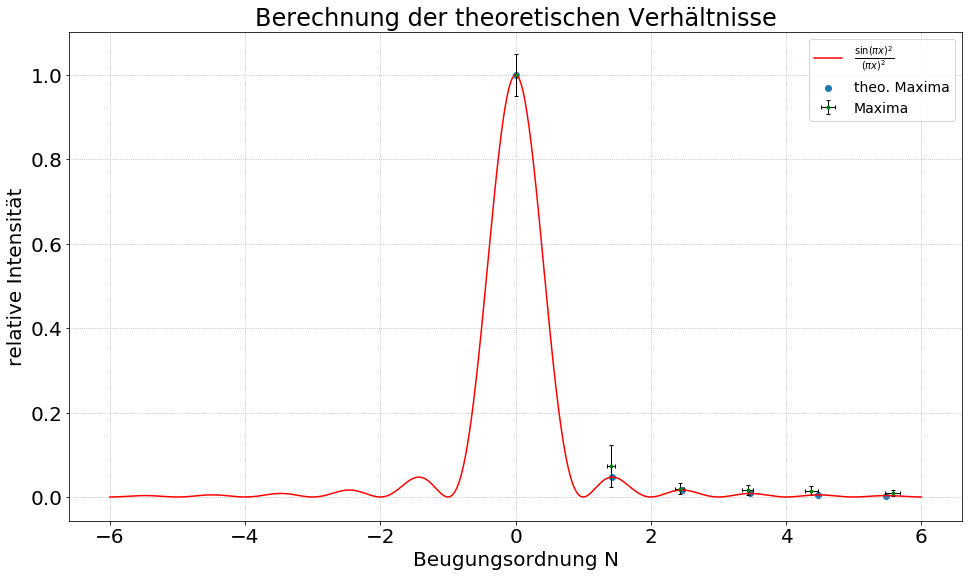

In [14]:
plt.errorbar(np.append(0,n_max_einzelspalt),I_max,
             xerr=np.append(0,dn_max_einzelspalt),
             yerr=dI_max,
             lw=1, ecolor='k', mec='g', mfc='g', fmt='.', capsize=2,label='Maxima')
plt.plot(x,beugung_spalt(x),color='red',label='$\\frac{\\sin{(\pi x)}^2}{(\pi x)^2}$')
plt.scatter(np.append(0,n_max_opt), np.append(1,max_theory_sliced),label='theo. Maxima')
plt.title('Berechnung der theoretischen Verhältnisse')
plt.xlabel('Beugungsordnung N')
plt.ylabel('relative Intensität')
plt.legend(loc='best',fontsize=14)
plt.grid(ls='dotted')
plt.show()

## Teil 2: Beugungsstruktur des Doppelspaltes

Wir wollen uns nun mit der Beugung am Doppelspalt beschäftigen, dazu wollen wir diesen Modellieren um die Qualität unserer Messwerte beurteilen zu können. Anders als beim Einzelspalt der mit der reltativen intensität und Beugungsordnung einheitlich, gibt es beim Doppelspalt einen zusätzlichen Parameter. Dieser ergibt sich aus der Spaltbreite $d$ und dem Spaltabstand $g$ (auch Gitterkonstante $g$), das sogenannte Spaltverhältniss $V$.

\begin{align}
    V = \frac{g}{d}
\end{align}

Um $V$ bestimmen zu können brauchen wir $g$ und $d$ welche wir aus den in Teil 4 der Durchführung gewonnen Fourierbildern gewinnen können.

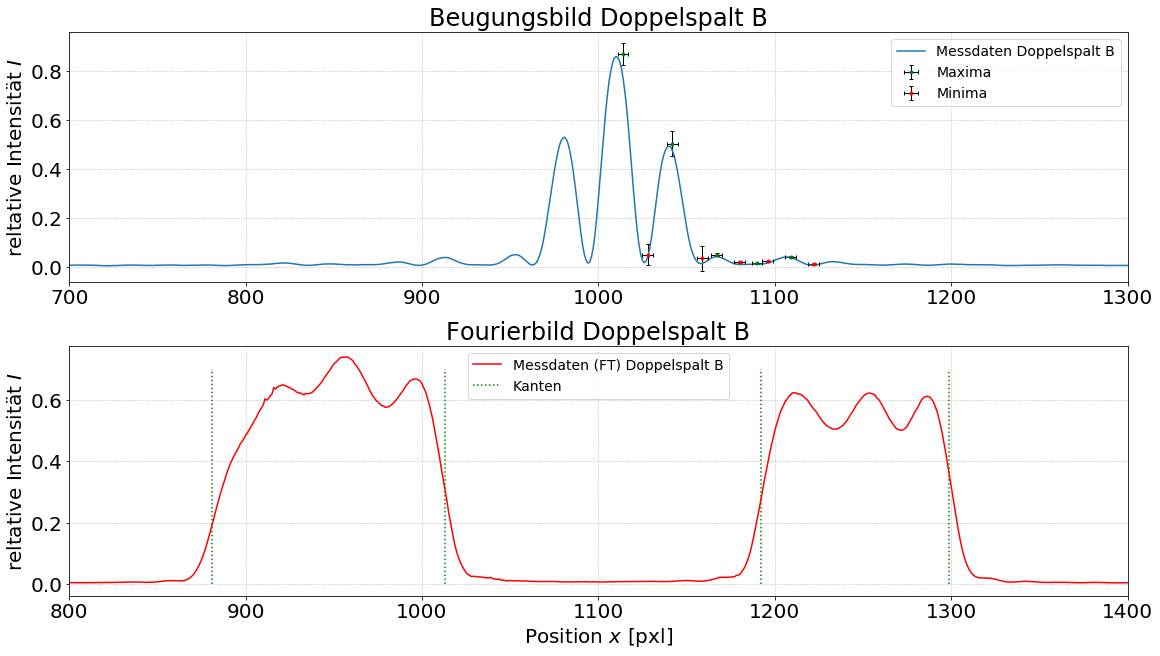

In [15]:
x_ds, I_ds = read_csv('Data/A2 Doppelspalt B Skizze.csv')
fx_ds, fI_ds = read_csv('Data/A4 Doppelspalt Funktion 2.csv')
x_max_ds0, dx_max_ds0, I_max_ds0, dI_max_ds0 = read_csv_rel('Data/A2 Doppelspalt Peaks.csv')
x_max_ds1, dx_max_ds1 = x_max_ds0[:2], dx_max_ds0[:2]
x_max_ds2, dx_max_ds2 = x_max_ds0[2:], dx_max_ds0[2:]
I_max_ds1, dI_max_ds1 = I_max_ds0[:2], dI_max_ds0[:2]
I_max_ds2, dI_max_ds2 = I_max_ds0[2:], dI_max_ds0[2:]

x_max_ds = np.append(x_max_ds1[:-1], x_max_ds2)
dx_max_ds = np.append(dx_max_ds1[:-1], dx_max_ds2)
I_max_ds = np.append(I_max_ds1[:-1], I_max_ds2*min(I_max_ds1))
dI_max_ds = np.append(dI_max_ds1[:-1], dI_max_ds2)

x_min_ds , I_min_ds = read_csv('Data/A2 Doppelspalt minima.csv')

diff = np.abs(np.diff(fI_ds))

from scipy.signal import find_peaks
peaks, _ = find_peaks(diff, height=0.02,distance=100)

fig, ax = plt.subplots(2, 1, constrained_layout=True)

ax[0].plot(x_ds,I_ds,label='Messdaten '+ 'Doppelspalt B')
ax[0].errorbar(x_max_ds, I_max_ds, 
               xerr=dx_max_ds, yerr=dI_max_ds,
               lw=1, ecolor='k', mec='g', mfc='g', fmt='.', capsize=2,label='Maxima')
ax[0].errorbar(x_min_ds, I_min_ds, 
               xerr=dx_max_ds, yerr=dI_max_ds,
               lw=1, ecolor='k', mec='r', mfc='r', fmt='.', capsize=2,label='Minima')
ax[0].set_title('Beugungsbild '+ 'Doppelspalt B')
ax[0].grid(ls=':')
ax[0].set_ylabel('reltative Intensität $I$')
ax[0].legend(loc='best',fontsize=14)
ax[0].set_xlim(1000-300,1000+300)
ax[1].plot(fx_ds,fI_ds,c='r',label='Messdaten (FT) '+ 'Doppelspalt B')
ax[1].vlines(peaks,ymin=0,ymax=0.7,color='g', linestyle= ':',label = 'Kanten')
ax[1].set_title('Fourierbild '+ 'Doppelspalt B')
ax[1].grid(ls=':')
ax[1].set_xlabel('Position $x$ [pxl]')
ax[1].set_ylabel('reltative Intensität $I$')
ax[1].legend(loc='best',fontsize=14)
ax[1].set_xlim(1100-300,1100+300)
plt.show()

### Bestimmung des Spaltabstandes $g$ und der -breite $d$

In [16]:
#Positionen der Ränder
pos_err= 3 #pxl
#links
x1_1= peaks[0]
x1_2= peaks[1]
#rechts
x2_1= peaks[2]
x2_2= peaks[3]

width_left=np.abs(x1_1-x1_2)
width_right=np.abs(x2_1-x2_2)

width_err=np.sqrt(2)*pos_err

width_mean=(width_left+width_right)/2
width_mean_err=np.sqrt((width_err/2)**2+(width_err/2)**2)


print('\nSpaltbreite der beiden einzelnen Spalte:\n')
print('d = ',form(width_mean,width_mean_err),' [pxl]')

#Berechnung des Spaltabstandes aus Mittelpunkten der Spalte

mid_left =(x1_1+x1_2)/2
mid_left_err = np.sqrt((pos_err/2)**2+(pos_err/2)**2)

mid_right =(x2_1+x2_2)/2
mid_right_err = np.sqrt((pos_err/2)**2+(pos_err/2)**2)

diff_mid = np.abs(mid_right-mid_left)
diff_mid_err = np.sqrt(mid_left_err**2+mid_right_err**2)

print('\nSpaltabstand des Doppelspalts:\n ')
print('g = ', form(diff_mid,diff_mid_err), ' [pxl]')

#Verhältnis des Spaltabstands zur Spaltbreite

prob_gd = diff_mid/width_mean
prob_gd_err = prob_gd*np.sqrt((diff_mid_err/diff_mid)**2+(width_mean_err/width_mean)**2)

print('\nVerhältnis aus Spaltabstand und Spaltbreite:\n')
print('V = ',form(prob_gd,prob_gd_err))


Spaltbreite der beiden einzelnen Spalte:

d =  119.500 ± 3.000  [pxl]

Spaltabstand des Doppelspalts:
 
g =  298.500 ± 3.000  [pxl]

Verhältnis aus Spaltabstand und Spaltbreite:

V =  2.498 ± 0.068


In [17]:
# Minima die einer Nullstelle enstprechen
def dist(a,b):
    return np.abs(a-b)

midF = np.mean([dist(x1_2,x2_1)/2+x1_2,dist(x2_2,x1_1)/2+x1_1])

# Gültige Abstände
valid = np.array([dist(x1_1,midF),dist(x1_2,midF),dist(x2_1,midF),dist(x2_2,midF)])

diff_min = x_min_ds-min(x_min_ds)

def intercept_range(x,y,rg):
    for i in range(len(x)):
        for j in range(len(y)):
            a = dist(x[i],y[j])
            if a<rg:
                return x[i],y[j],a
null, min0, dmin0 = intercept_range(valid,diff_min,3)
ind = list(diff_min).index(min0)
print('Das Minimum %d'%ind+'ter Ordnung ist eine Nullstelle der Spaltfunktion')
print('Unsicherheit: ', dmin0, ' [pxl]')

Das Minimum 4ter Ordnung ist eine Nullstelle der Spaltfunktion
Unsicherheit:  1.75  [pxl]


### Vergleich der Maxima und Minima

#### Bestimmung der Beugungsfunktion des Doppelspalts

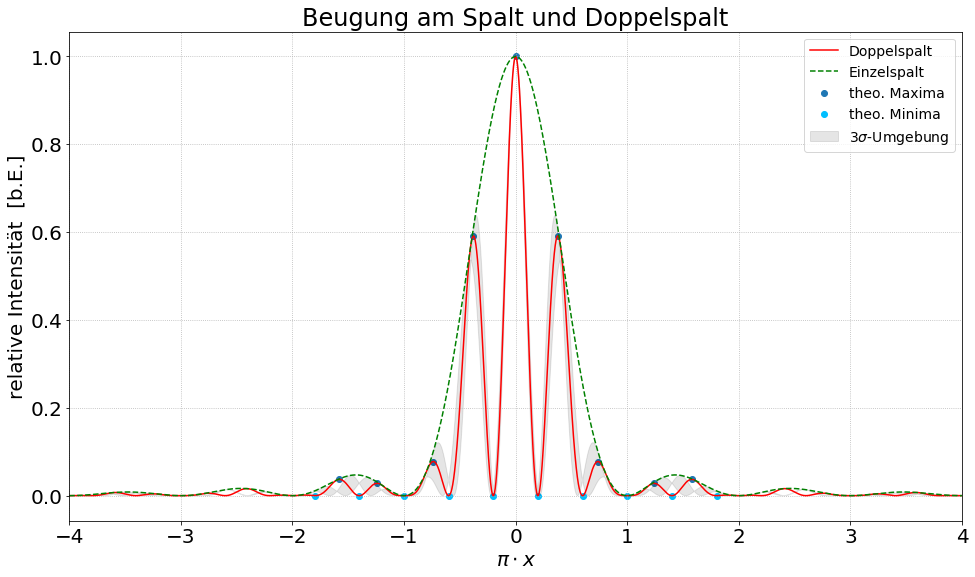

In [18]:
v=prob_gd
nstd=3 # Sigma-Umgebung
v_bot=prob_gd-prob_gd_err*nstd
v_top=prob_gd+prob_gd_err*nstd

a=5
x=np.linspace(-(a+1),a+1,200001)

def beugung_ds(x,v):
    return np.sinc(x)**2*np.cos(np.pi*v*x)**2

from scipy.signal import find_peaks
peaks1, _ = find_peaks(beugung_ds(x,v), height=0.025,distance=100)
peaks2, _ = find_peaks(-1*beugung_ds(x,v), height=-1e-3,distance=100)
n_max_opt = x[peaks1][4:]
n_min_opt = x[peaks2][17:22]
I_max_theo = beugung_ds(x,v)[peaks1][4:]
I_min_theo = beugung_ds(x,v)[peaks2][17:22]

plt.scatter(x[peaks1],beugung_ds(x,v)[peaks1],label = 'theo. Maxima')
plt.scatter(x[peaks2][12:22],beugung_ds(x,v)[peaks2][12:22],c='deepskyblue',label = 'theo. Minima')
plt.plot(x,beugung_ds(x,v),color='r',label='Doppelspalt')
plt.plot(x,beugung_spalt(x),color='g',label='Einzelspalt',linestyle='--')
plt.fill_between(x, beugung_ds(x,v_top), beugung_ds(x,v_bot), color='k', 
                alpha=.1, label=str(nstd)+r'$\sigma$'+'-Umgebung')
plt.title('Beugung am Spalt und Doppelspalt')
plt.xlabel('$\pi \cdot x$')
plt.ylabel('relative Intensität  [b.E.]')
plt.xlim(-4,4)
plt.grid(ls=':')
plt.legend(loc='best',fontsize=14)
plt.show()

#### Vergleich der Theorie-Kurve mit den Messwerten


Fitgüte Minima:

chi_squared= 6.420920856725045
chi_squared_red= 2.1403069522416818
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 9.3 %



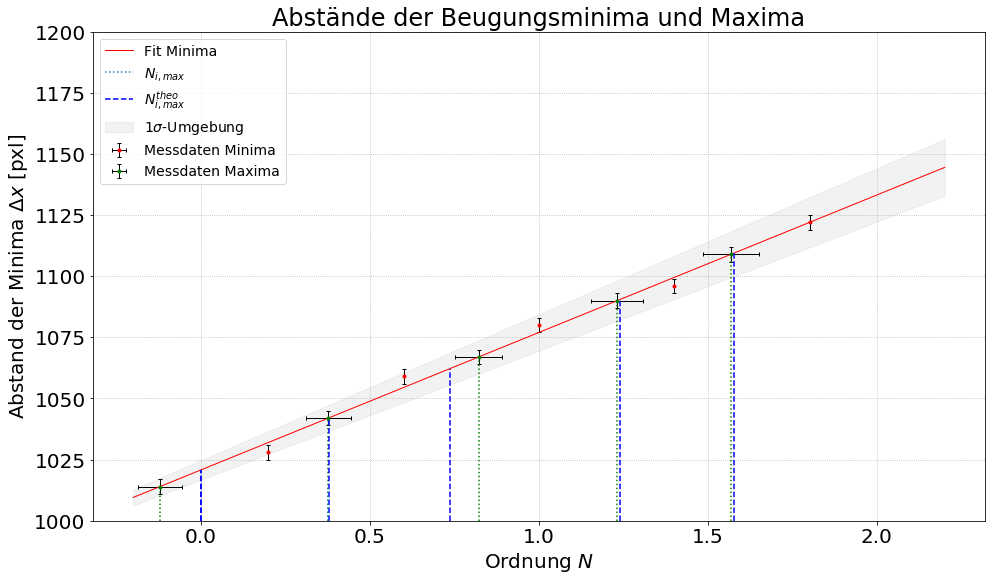

In [19]:
n_min_ds = n_min_opt
dn_min_ds = np.full(n_min_ds.size,1e-6)
x_min_ds = read_csv('Data/A2 Doppelspalt minima.csv')[0]
dx_min_ds = np.full(x_min_ds.size,3)

popt, perr = fit(n_min_ds,dn_min_ds,
                 x_min_ds,dx_min_ds,
                  'r','Minima',[1,1],fit_func,0.4)

def fit_func_umkehr(p, x):
        (s,a) = p 
        return (x-a)/s

n_max_ds = fit_func_umkehr(popt,x_max_ds)
dn_max_ds = np.sqrt((dx_max_ds/popt[0])**2+
                                   (perr[1]**0.5/popt[0])**2+
                                   ((x_max_ds-popt[1])*perr[0]**0.5/popt[0]**2)**2)

plt.errorbar(n_max_ds[0:], x_max_ds[0:], 
             xerr=dn_max_ds[0:], yerr=dx_max_ds[0:],
             lw=1, ecolor='k', mec='g', mfc='g', fmt='.', capsize=2,label='Messdaten Maxima')

for i in range(0,len(n_max_ds)): 
    n = n_max_ds[i]
    b = n_max_opt[i]
    dn = dn_max_ds[i]
    plt.axvline(n,ymin=0,ymax=(x_max_ds[i]-1000)/(1200-1000),ls=':',c='g')
    plt.axvline(b,ymin=0,ymax=(fit_func(popt,b)-1000)/(1200-1000),ls='--',c='b')
    
plt.axvline(n_max_ds[1],ymin=0,ymax=(x_max_ds[0]-1000)/(1200-1000),ls=':',
            label='$N_{i,max}$')
plt.axvline(n_max_opt[0],ymin=0,ymax=(fit_func(popt,n_max_opt[0])-1000)/(1200-1000),ls='--',
            c='b',label='$N_{i,max}^{theo}$')
plt.ylim([1000,1200])
plt.title('Abstände der Beugungsminima und Maxima')
plt.grid(ls=':')
plt.xlabel('Ordnung $N$')
plt.ylabel('Abstand der Minima $\Delta x$ [pxl]')
plt.legend(loc='best',fontsize=14)
plt.show()


Beugungsordnung der Maxima:

N_1 = -0.120 ± 0.064
N_1_theo = 0.0
sigma =  3.507 

N_2 = 0.378 ± 0.065
N_2_theo = 0.378
sigma =  0.0 

N_3 = 0.823 ± 0.070
N_3_theo = 0.737
sigma =  1.502 

N_4 = 1.232 ± 0.076
N_4_theo = 1.241
sigma =  0.013 

N_5 = 1.570 ± 0.083
N_5_theo = 1.578
sigma =  0.01 


Relative Intensitäten der Maxima:

I_1/I_0_mes  = 8.713647e-01  ±  4.356823e-02
I_1/I_0_theo = 1e+00
sigma = 8.717 

I_2/I_0_mes  = 5.044743e-01  ±  5e-02
I_2/I_0_theo = 5.914028e-01
sigma = 3.023 

I_3/I_0_mes  = 5.135029e-02  ±  5.089485e-03
I_3/I_0_theo = 7.772258e-02
sigma = 26.85 

I_4/I_0_mes  = 1.692867e-02  ±  1.677852e-03
I_4/I_0_theo = 2.807773e-02
sigma = 44.154 

I_5/I_0_mes  = 4.288596e-02  ±  4.250559e-03
I_5/I_0_theo = 3.702529e-02
sigma = 1.901 



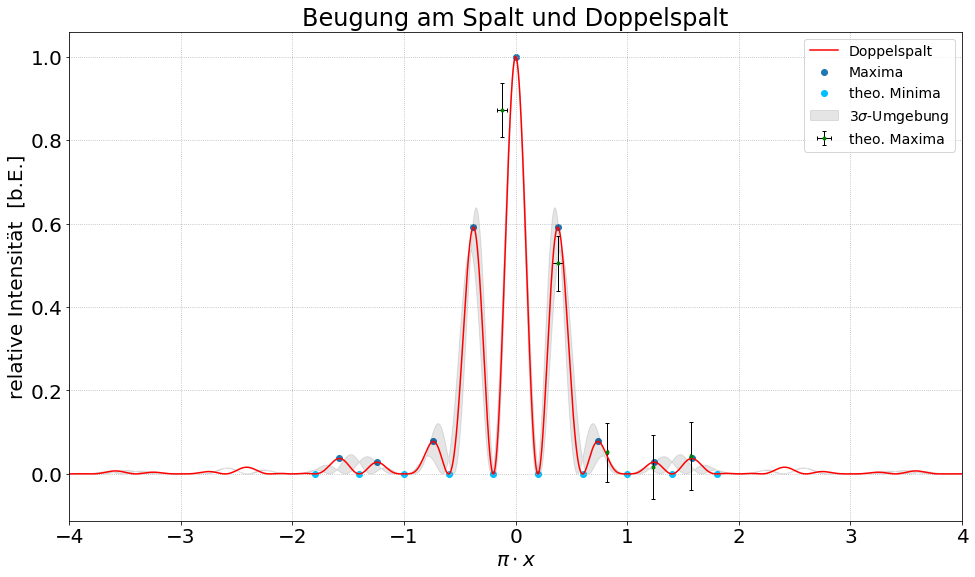

In [20]:
print('\nBeugungsordnung der Maxima:\n')
for i in range(len(n_max_einzelspalt)):
    n = n_max_ds[i]
    dn = dn_max_ds[i]
    sigma = sig(n,dn,n_max_opt[i],0)
    print('N_%d ='%(i+1), form(n,dn))
    print('N_%d_theo ='%(i+1), round(n_max_opt[i],3))
    print('sigma = ',sigma, '\n')

print('\nRelative Intensitäten der Maxima:\n')
for i in range(0,len(I_max)-1):
    print('I_%d/I_0_mes  ='%(i+1), format_e(I_max_ds[i]), ' ± ', format_e(dI_max_ds[i]))   
    print('I_%d/I_0_theo ='%(i+1),format_e(I_max_theo[i]))
    print('sigma =', sig(I_max_ds[i],dI_max_ds[i],I_max_theo[i],0),'\n')
    
plt.errorbar(n_max_ds,I_max_ds,dn_max_ds,dI_max_ds,
             lw=1, ecolor='k', mec='g', mfc='g', fmt='.', capsize=2,label='theo. Maxima')
plt.scatter(x[peaks1],beugung_ds(x,v)[peaks1],label = 'Maxima')
plt.scatter(x[peaks2][12:22],beugung_ds(x,v)[peaks2][12:22],c='deepskyblue',label = 'theo. Minima')
plt.plot(x,beugung_ds(x,v),color='r',label='Doppelspalt')
plt.fill_between(x, beugung_ds(x,v_top), beugung_ds(x,v_bot), color='k', 
                alpha=.1, label=str(nstd)+r'$\sigma$'+'-Umgebung')
plt.title('Beugung am Spalt und Doppelspalt')
plt.xlabel('$\pi \cdot x$')
plt.ylabel('relative Intensität  [b.E.]')
plt.xlim(-4,4)
plt.grid(ls=':')
plt.legend(loc='best',fontsize=14)
plt.show()

Der Vergleich der relativen Intensitäten und Ordnungen der Maxima wurde in folgender Tabelle zusammengefasst:

| $N_{theo}$ | $N_{mes}$ | $\sigma$-Abw. | $\frac{I^\text{theo}}{I_0}$ | $\frac{I^\text{mes}}{I_0}$ | $\sigma$-Abw. |
|---|---|---|---|---|---|
| 0.000 | -0.120 $\pm$ 0.064 | 3.51 | 1 | 0.871 $\pm$ 0.044 | 8.72 |
| 0.378 | 0.378 $\pm$ 0.065 | 0.00 | 0.591 | 0.505 $\pm$ 0.050 | 3.02 |
| 0.737 | 0.823 $\pm$ 0.070 | 1.50 | 0.077 | 0.051 $\pm$ 0.005 | 26.85 |
| 1.241 | 1.232 $\pm$ 0.076 | 0.01 | 0.028 | 0.017 $\pm$ 0.002 | 44.15 |
| 1.578 | 1.570 $\pm$ 0.083 | 0.01 | 0.037 | 0.043 $\pm$ 0.004 | 1.90 |

### Vergleich relative Intensität Nebenmaxima und erstes Minimum Spaltfunktion

In [21]:
# Berechnung erstes Minimum Spaltfunktion

peaks3, _ = find_peaks(-fI_ds, height=(-0.7,-0.6),distance=30)
Imin1 = np.mean(fI_ds[peaks3])

print('\nrel. Intensität erstes Minimum der Spaltfunktion:\n')
print('rel. I_min_spalt = ', Imin1,'\n')
for i in range(len(I_max_ds)):
    print('rel. I_%d      ='%i, form(I_max_ds[i],dI_max_ds[i]))
    print('sigma = ', sig(Imin1, 0, I_max_ds[i],dI_max_ds[i]),'\n')


rel. Intensität erstes Minimum der Spaltfunktion:

rel. I_min_spalt =  0.61854219 

rel. I_0      = 0.871 ± 0.044
sigma =  33.674 

rel. I_1      = 0.504 ± 0.050
sigma =  5.205 

rel. I_2      = 0.051 ± 0.005
sigma =  12419.734 

rel. I_3      = 0.017 ± 0.002
sigma =  128566.464 

rel. I_4      = 0.043 ± 0.004
sigma =  18341.475 



Somit folgt das das **erste Nebenmaximum** der Intensität des ersten Minimums am nächsten kommt. Allerdings signifikant verschieden ist.

## Teil 3: Das Objektbild als Fouriersynthese

In [22]:
# Integrand Einzelspalt
def spalt(k):
    return d/np.pi*np.sin(k*d/2)/(k*d/2)*np.cos(yi*k)

# Integrand zu 57, Doppelspalt
def doppelspalt(k):
    return d/np.pi*np.cos(k*g/2)*np.sin(k*d/2)/(k*d/2)*np.cos(yi*k)

# Funktion zur berechnung und zum plot des resultierenden Objektbildes

d = b #bestimmt aus Messung mit n=15
def picture(
           function, # Integrand
           b,        # Integrationsbereich bezüglich der Nullstellen
           dateiname):
    
    # Definieren der Funktionsvariable
    global n
    global g
    g = 2*d
    n = b
    
    if function == spalt:
        y = np.linspace(-d, d, 301)
    else:
        y = np.linspace(-g, g, 501)
    
    # Berechnung des Objektbiles
    f_mod = []
    for i in range(len(y)): # numerische Inegration
        global yi 
        yi = y[i]
        result, error = quad(function, 0, 2*np.pi*n/d)
        f_mod.append(result**2)
    f_mod = f_mod/np.max(f_mod)
    
    # Lage der Maxima
    max1 = argrelextrema(f_mod, np.greater_equal, order = 1)
    f_max1 = f_mod[max1]
    y_max1 = y[max1]
    max2 = (f_max1 > 0.05)
    f_max = f_max1[max2]
    y_max = y_max1[max2]
    
    # Lage der Minima
    min1 = argrelextrema(f_mod, np.less_equal, order = 1)
    f_min1 = f_mod[min1]
    y_min1 = y[min1]
    min2 = (f_min1 > 0.05)
    f_min = f_min1[min2]
    y_min = y_min1[min2]
    
    # Plot
    plt.figure(dateiname)
    plt.plot(y, f_mod, color = 'r', linewidth = 1.5, label='theo. Spaltfunktion')
    plt.grid(ls=':')
    plt.scatter(y_max, f_max, label = 'Maxima')
    plt.scatter(y_min, f_min, color = 'deepskyblue', label = 'Minima')
    plt.xlabel('y / d')
    plt.ylabel('rel. Intensität [b. E.]')
    plt.legend(loc='best',fontsize=14)
    plt.title('%s' %dateiname)
    plt.ylim((0, 1.1))
    plt.show()
    
    # Ausgabe der Lage der Maxima und Minima
    return y_max, f_max, y_min, f_min
    

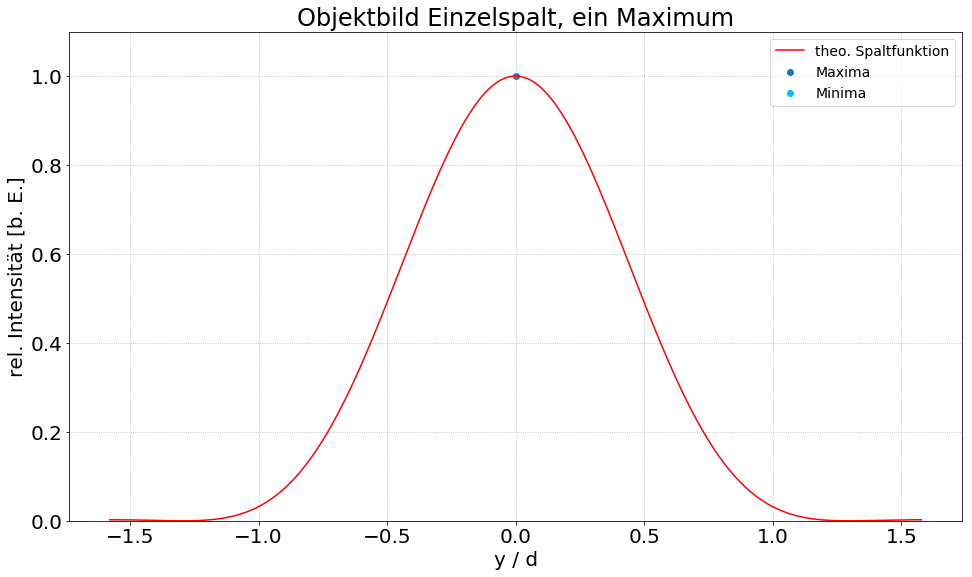

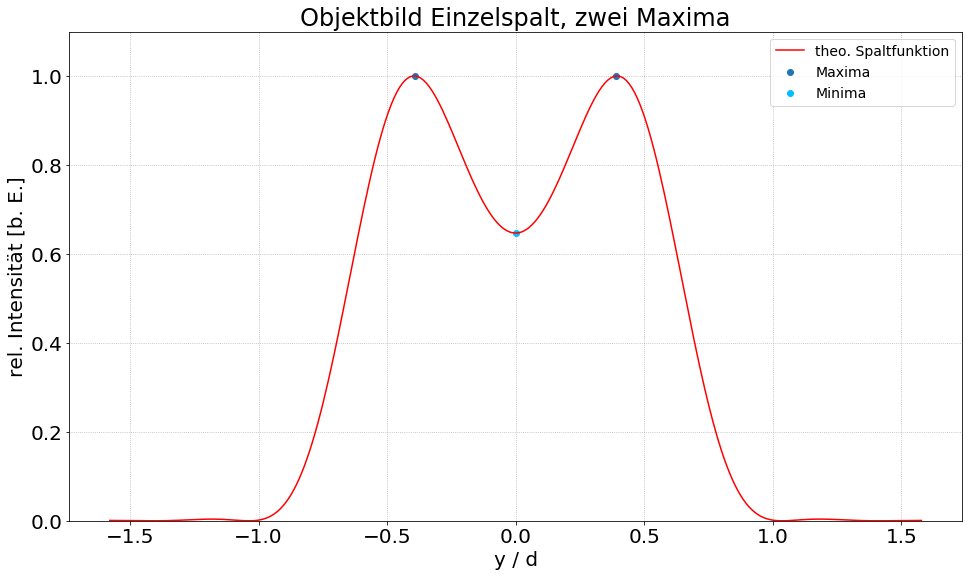

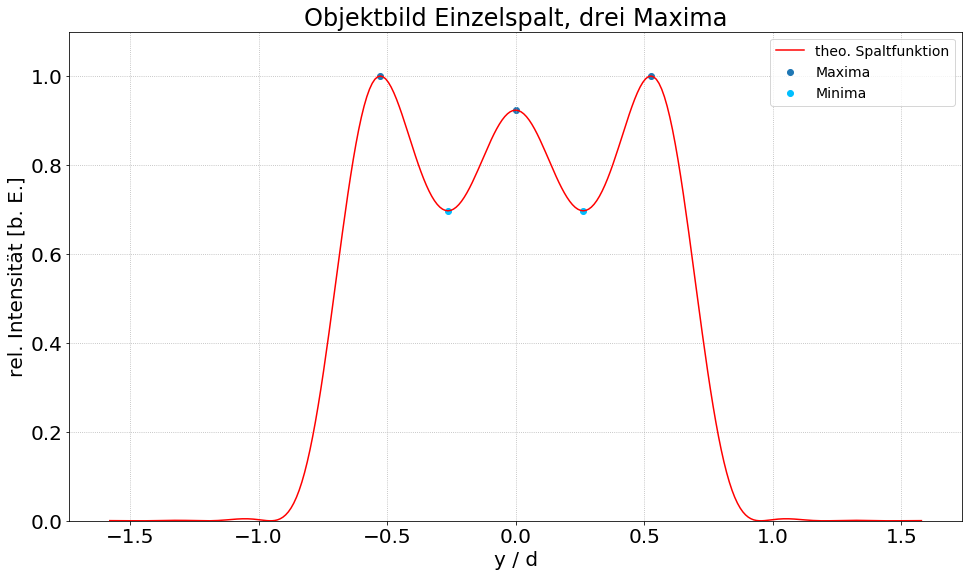

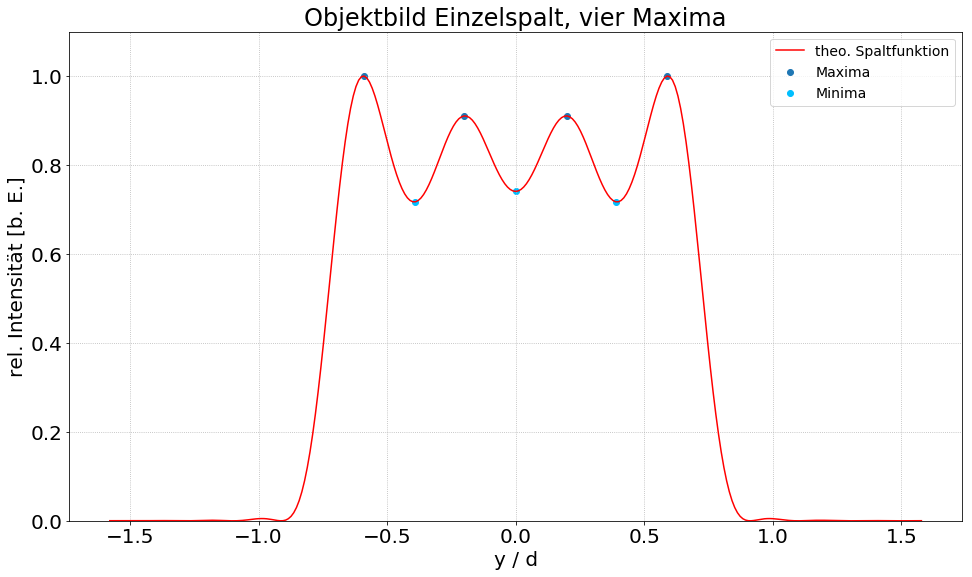

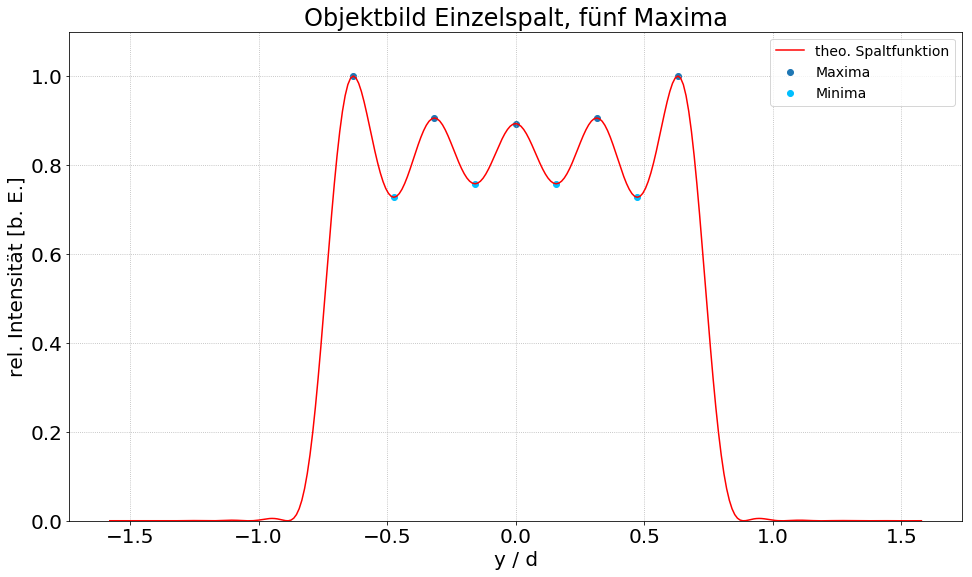

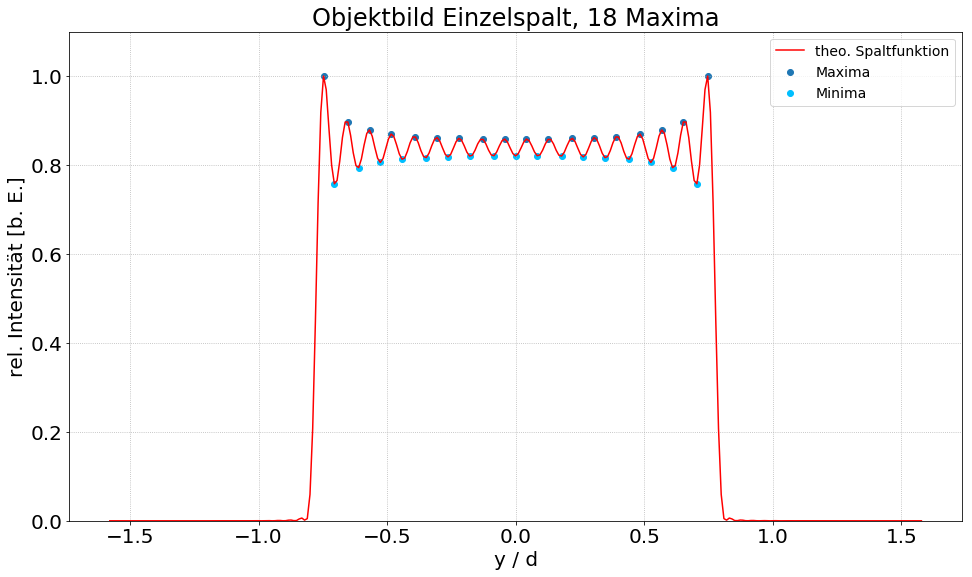

In [23]:
#Plotten der Einzelspaltbilder
maxPos_spalt1, maxInt_spalt1, minPos_spalt1, minInt_spalt1 = picture(spalt, 1, 'Objektbild Einzelspalt, ein Maximum')
maxPos_spalt2, maxInt_spalt2, minPos_spalt2, minInt_spalt2 = picture(spalt, 2, 'Objektbild Einzelspalt, zwei Maxima')
maxPos_spalt3, maxInt_spalt3, minPos_spalt3, minInt_spalt3 = picture(spalt, 3, 'Objektbild Einzelspalt, drei Maxima')
maxPos_spalt4, maxInt_spalt4, minPos_spalt4, minInt_spalt4 = picture(spalt, 4, 'Objektbild Einzelspalt, vier Maxima')
maxPos_spalt5, maxInt_spalt5, minPos_spalt5, minInt_spalt5 = picture(spalt, 5, 'Objektbild Einzelspalt, fünf Maxima')
maxPos_spalt18, maxInt_spalt18, minPos_spalt18, minInt_spalt18 = picture(spalt, 18, 'Objektbild Einzelspalt, 18 Maxima')

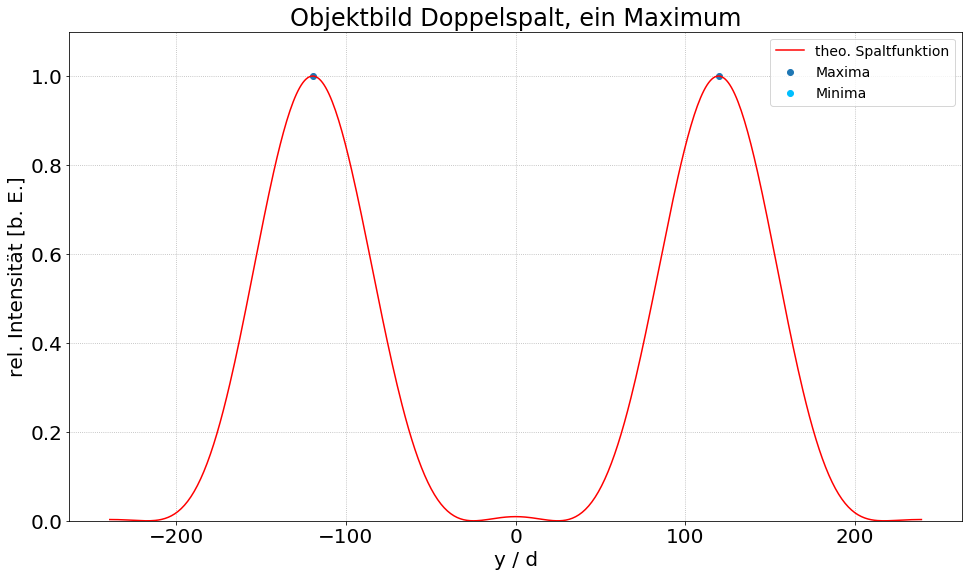

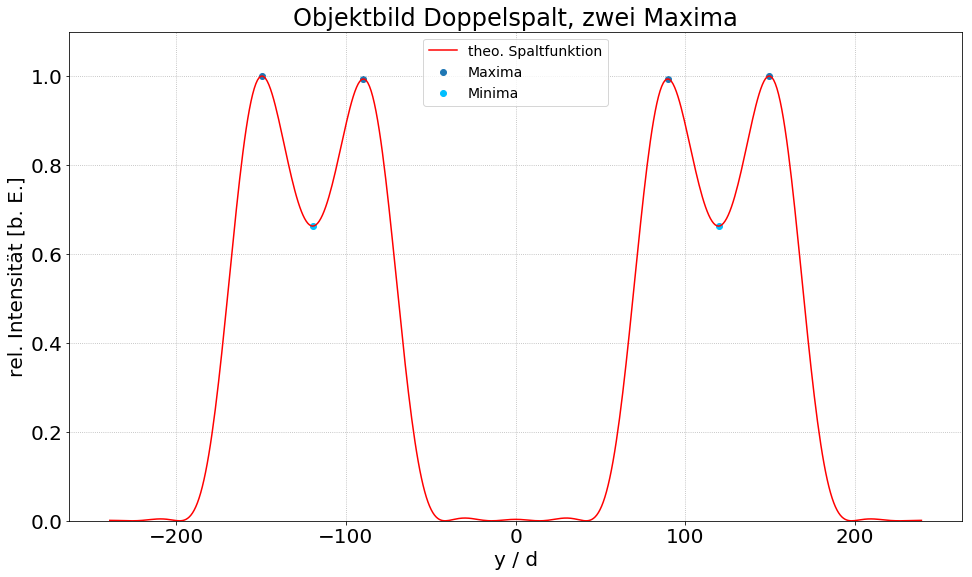

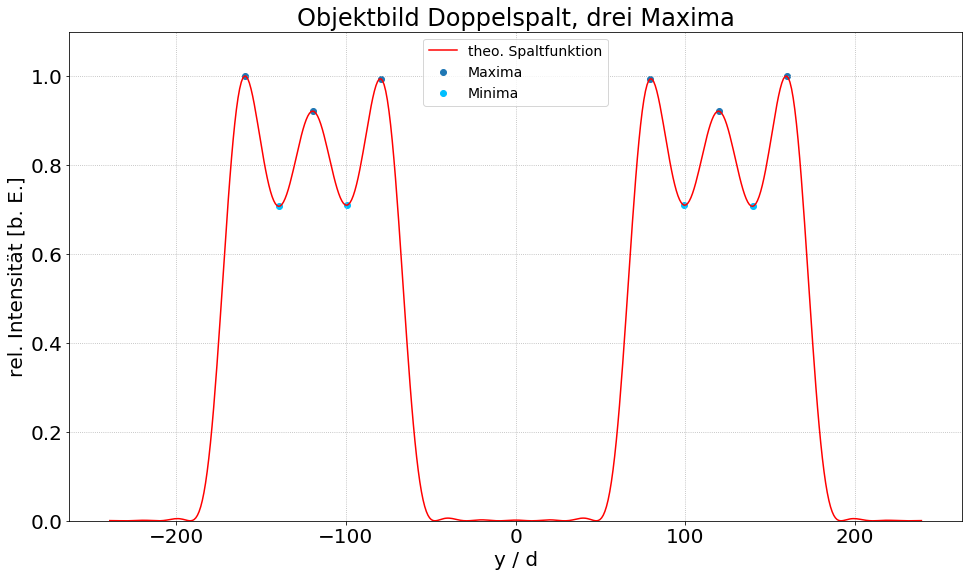

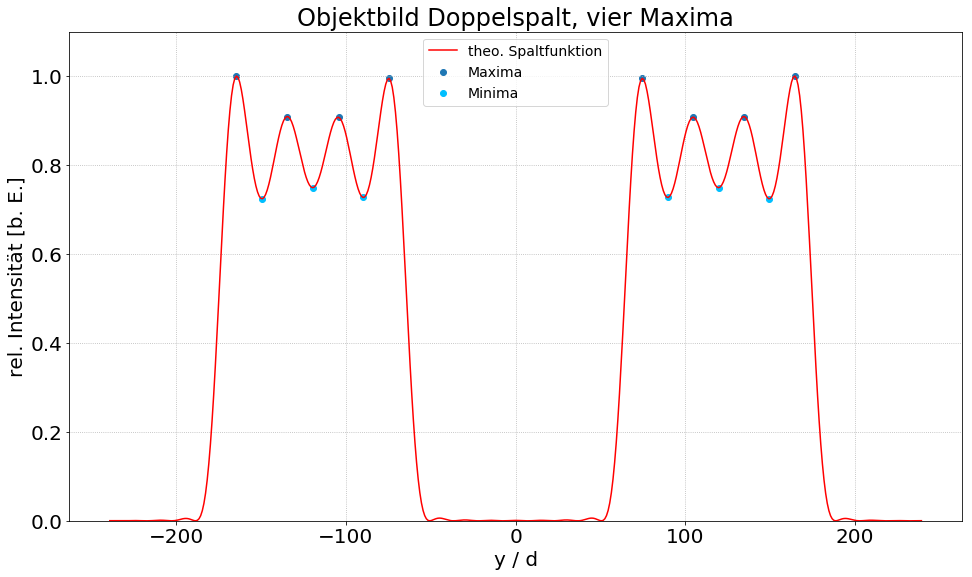

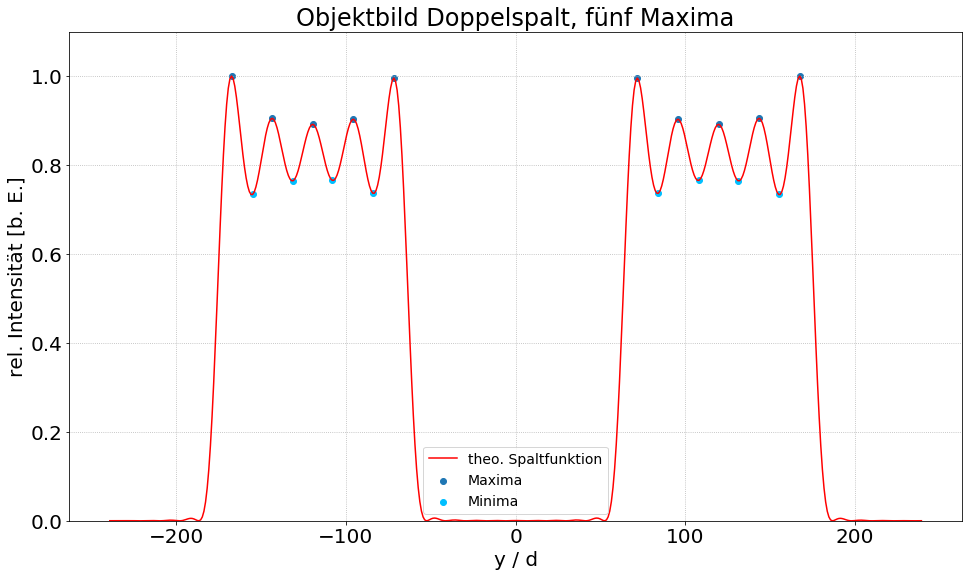

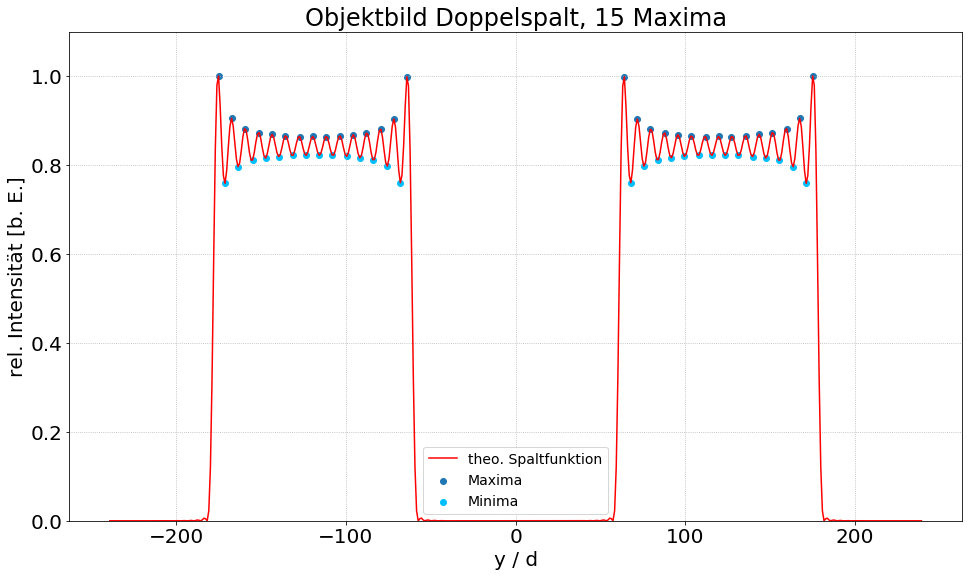

In [24]:
#Doppelspalt
d=width_mean
g=diff_mid

#Plotten der Doppelspaltbilder mit zuver berechnetem d und g
maxPos_dspalt1, maxInt_dspalt1, minPos_dspalt1, minInt_dspalt1 = picture(doppelspalt, 1, 'Objektbild Doppelspalt, ein Maximum')
maxPos_dspalt2, maxInt_dspalt2, minPos_dspalt2, minInt_dspalt2 = picture(doppelspalt, 2, 'Objektbild Doppelspalt, zwei Maxima')
maxPos_dspalt3, maxInt_dspalt3, minPos_dspalt3, minInt_dspalt3 = picture(doppelspalt, 3, 'Objektbild Doppelspalt, drei Maxima')
maxPos_dspalt4, maxInt_dspalt4, minPos_dspalt4, minInt_dspalt4 = picture(doppelspalt, 4, 'Objektbild Doppelspalt, vier Maxima')
maxPos_dspalt5, maxInt_dspalt5, minPos_dspalt5, minInt_dspalt5 = picture(doppelspalt, 5, 'Objektbild Doppelspalt, fünf Maxima')
maxPos_dspalt15, maxInt_dspalt15, minPos_dspalt15, minInt_dspalt15 = picture(doppelspalt, 15, 'Objektbild Doppelspalt, 15 Maxima')

### a) Bestimmung der Abstände der "wiggles" (Theorie und Experiment)

In [25]:
# Funktion zum Bestimmen der Extrema
def distance(pos):
    Pos = []
    if len(pos) < 2:
        True
    else:
        for i in range(len(pos) - 1):
            Pos.append(pos[i+1] - pos[i])
    return np.round(Pos, 1)

def distance_err(pos_err):
    Pos_err = []
    if len(pos_err) < 2:
        True
    else:
        for i in range(len(pos_err) - 1):
            Pos_err.append(np.sqrt(pos_err[i+1]**2 + pos_err[i]**2))
    return np.round(Pos_err, 1)

In [26]:
# Bestimmen der theoretischen Abstände der Maxima und Minima
dist_spalt1_max = distance(maxPos_spalt1) 
dist_spalt2_max = distance(maxPos_spalt2) 
dist_spalt3_max = distance(maxPos_spalt3) 
dist_spalt18_max = distance(maxPos_spalt18)

dist_spalt1_min = distance(minPos_spalt1) 
dist_spalt2_min = distance(minPos_spalt2) 
dist_spalt3_min = distance(minPos_spalt3) 
dist_spalt18_min = distance(minPos_spalt18)

# selbiges für Experimentelle Werte, mit Fehlern
maxPos_spalt1_ex = np.array([1247.19])
maxPos_spalt2_ex = np.array([1101, 1171])
maxPos_spalt3_ex = np.array([1090, 1138, 1183])
maxPos_spalt18_ex = np.array([1183.06,1191.27,1198.52,
                              1205.92,1212.69,1219.93,
                              1227.66,1235.39,1241.83,
                              1249.72,1257.93,1264.69,
                              1271.62,1279.51,1286.75,
                              1294.00,1301.89,1310.26]) 

maxPos_spalt1_ex_err = np.array([3])
maxPos_spalt2_ex_err = np.array([3, 3])
maxPos_spalt3_ex_err = np.array([3, 3, 3])
maxPos_spalt18_ex_err = np.ones(18)

minPos_spalt1_ex = np.array([])
minPos_spalt2_ex = np.array([1246.34])
minPos_spalt3_ex = np.array([1222.29,1270.40])
minPos_spalt18_ex = np.array([1187.89,1194.97,1201.90,
                              1209.47,1216.71,1223.96,
                              1231.69,1238.13,1245.37,
                              1253.75,1261.80,1268.40,
                              1275.64,1283.21,1290.78,
                              1297.86,1305.43])

minPos_spalt1_ex_err = np.array([])
minPos_spalt2_ex_err = np.array([3])
minPos_spalt3_ex_err = np.array([3, 3])
minPos_spalt18_ex_err = np.ones(17)

# Bestimmen der theoretischen Abstände der Maxima und Minima
dist_spalt1_max_ex = distance(maxPos_spalt1_ex) 
dist_spalt2_max_ex = distance(maxPos_spalt2_ex) 
dist_spalt3_max_ex = distance(maxPos_spalt3_ex)
dist_spalt18_max_ex = distance(maxPos_spalt18_ex)

dist_spalt1_max_ex_err = distance_err(maxPos_spalt1_ex_err) 
dist_spalt2_max_ex_err = distance_err(maxPos_spalt2_ex_err) 
dist_spalt3_max_ex_err = distance_err(maxPos_spalt3_ex_err)
dist_spalt18_max_ex_err = distance_err(maxPos_spalt18_ex_err)

dist_spalt1_min_ex = distance(minPos_spalt1_ex) 
dist_spalt2_min_ex = distance(minPos_spalt2_ex) 
dist_spalt3_min_ex = distance(minPos_spalt3_ex)
dist_spalt18_min_ex = distance(minPos_spalt18_ex)

dist_spalt1_min_ex_err = distance_err(minPos_spalt1_ex_err) 
dist_spalt2_min_ex_err = distance_err(minPos_spalt2_ex_err) 
dist_spalt3_min_ex_err = distance_err(minPos_spalt3_ex_err)
dist_spalt18_min_ex_err = distance_err(minPos_spalt18_ex_err)

In [27]:
# Theoretische Abstände der Maxima und Minima für den Doppelspalt, 15 Maxima
dist_dspalt18_max = distance(maxPos_dspalt15[15:]) 
dist_dspalt18_min = distance(minPos_dspalt15[15:]) 

# Bestimmen der theoretischen Abstände der Maxima und Minima
dist_dspalt15_max_ex = distance(maxPos_dspalt15_ex)
dist_dspalt15_max_ex_err = distance_err(maxPos_dspalt15_ex_err)

dist_dspalt15_min_ex = distance(minPos_dspalt15_ex)
dist_dspalt15_min_ex_err = distance_err(minPos_dspalt15_ex_err)

### Vergleich des Einzelspaltes

#### Maxima

In [86]:
#direkt Umrechnung in mm durch Multiplikation mit 14micrometer*g
pxl_to_m=14e-6*9.123e-2
g_err=0.01e-2

def PPrint(n, v1, dv1, v2, dv2, sy, sub):
    print('\n'+n+'\n')
    for i in range(len(v1)):
        print(sy+'_%d ='%i, form(v1[i],dv1[i]))
        print(sy+'_%d_'%i+sub+' =', form(v2[i],0))
        print('sigma = ', sig(v1[i],dv1[i],v2[i],0),'\n')
        
PPrint('Theoretische Abstände zwei Maxima:', 
       dist_spalt2_max_ex*0.01, dist_spalt2_max_ex_err*0.01, dist_spalt2_max, 0, 'dist_2max', 'theo')
PPrint('Theoretische Abstände drei Maxima:', 
       dist_spalt3_max_ex*0.01, dist_spalt3_max_ex_err*0.01, dist_spalt3_max, 0, 'dist_3max', 'theo')
PPrint('Theoretische Abstände 18 Maxima:', 
       dist_spalt18_max_ex*0.01, dist_spalt18_max_ex_err*0.01, dist_spalt18_max, 0, 'dist_18max', 'theo')

#### Minima

In [89]:
PPrint('Theoretische Abstände zwei Minima:', 
       dist_spalt3_min_ex*0.01, dist_spalt3_min_ex_err*0.01, dist_spalt3_min, 0, 'dist_3min', 'theo')
PPrint('Theoretische Abstände 17 Minima:', 
       dist_spalt18_min_ex*0.01, dist_spalt18_min_ex_err*0.01, dist_spalt18_min, 0, 'dist_17min', 'theo')


Theoretische Abstände zwei Minima:

dist_3min_0 = 0.481 ± 0.042
dist_3min_0_theo = 0.500 ± 0.000
sigma =  0.205 


Theoretische Abstände 17 Minima:

dist_17min_0 = 0.071 ± 0.014
dist_17min_0_theo = 0.100 ± 0.000
sigma =  4.291 

dist_17min_1 = 0.069 ± 0.014
dist_17min_1_theo = 0.100 ± 0.000
sigma =  4.903 

dist_17min_2 = 0.076 ± 0.014
dist_17min_2_theo = 0.100 ± 0.000
sigma =  2.939 

dist_17min_3 = 0.072 ± 0.014
dist_17min_3_theo = 0.100 ± 0.000
sigma =  4.0 

dist_17min_4 = 0.072 ± 0.014
dist_17min_4_theo = 0.100 ± 0.000
sigma =  4.0 

dist_17min_5 = 0.077 ± 0.014
dist_17min_5_theo = 0.100 ± 0.000
sigma =  2.699 

dist_17min_6 = 0.064 ± 0.014
dist_17min_6_theo = 0.100 ± 0.000
sigma =  6.612 

dist_17min_7 = 0.072 ± 0.014
dist_17min_7_theo = 0.100 ± 0.000
sigma =  4.0 

dist_17min_8 = 0.084 ± 0.014
dist_17min_8_theo = 0.100 ± 0.000
sigma =  1.306 

dist_17min_9 = 0.080 ± 0.014
dist_17min_9_theo = 0.100 ± 0.000
sigma =  2.041 

dist_17min_10 = 0.066 ± 0.014
dist_17min_10_theo = 0.100

### b) Vergleich der rel. Intensitäten der Extrema 

In [29]:
# erstes Bild als Eichmessung
I0_max_0=2971.51
intensity_err = 10

ug0_mean=(233.64+228.58)/2
ug0_mean_err=np.sqrt(50) 
ug0_mean_std=np.std(np.array([233.64,228.58]))/np.sqrt(2)

I0_max_0_corr=I0_max_0-ug0_mean
I0_max_0_corr_err=np.sqrt(intensity_err**2+ug0_mean_err**2)
I0_max_0_corr_std=ug0_mean_std

#ab hier wird direkt der um den Untergrund abgezogene Wert angegeben. Berechnung analog wie zuvor.

# zweites Bild
max2_mean=2819.66-(209.27+205.63)/2
max2_mean_err=np.sqrt(2*ug0_mean_err**2)
max2_mean_std=np.sqrt((np.std(np.array([2809.80,2829.52])/
                              np.sqrt(2))**2)+(np.std(np.array([209.27,205.63])/np.sqrt(2)))**2)

min2=1961.63-(209.27+205.63)/2
min2_err=np.sqrt(intensity_err**2+ug0_mean_err**2)
min2_std=np.std(np.array([209.27,205.63]))/np.sqrt(2)

# drittes Bild
max3_mean=(2752.25+2584.04+2691.76)/3-(210.36+207.89)/2
max3_mean_err=np.sqrt((300/9)**2+ug0_mean_err**2)
max3_mean_std=np.sqrt((np.std(np.array([2752.25,2584.04,2691.76])/
                              np.sqrt(3))**2)+(np.std(np.array([210.36,207.89])/np.sqrt(2)))**2)

min3_mean=((2215.22+2088.24)-(210.36+207.89))/2
min3_mean_err=np.sqrt(2*ug0_mean_err**2)
min3_mean_std=np.sqrt((np.std(np.array([2215.22,2088.24])/
                              np.sqrt(2))**2)+(np.std(np.array([210.36,207.89]))/np.sqrt(2))**2)

In [30]:
#Verhältnisse zu I0

I_rel_max2 = max2_mean/I0_max_0_corr
I_rel_max2_err = I_rel_max2*np.sqrt((max2_mean_err/max2_mean)**2+(I0_max_0_corr_err/I0_max_0_corr)**2)
I_rel_max2_std = I_rel_max2*np.sqrt((max2_mean_std/max2_mean)**2+(I0_max_0_corr_std/I0_max_0_corr)**2)
I_rel_min2 = min2/I0_max_0_corr
I_rel_min2_err = I_rel_min2*np.sqrt((min2_err/min2)**2+(I0_max_0_corr_err/I0_max_0_corr)**2)
I_rel_min2_std = I_rel_min2*np.sqrt((min2_std/min2)**2+(I0_max_0_corr_std/I0_max_0_corr)**2)

I_rel_max3 = max3_mean/I0_max_0_corr
I_rel_max3_err = I_rel_max3*np.sqrt((max3_mean_err/max3_mean)**2+(I0_max_0_corr_err/I0_max_0_corr)**2)
I_rel_max3_std = I_rel_max3*np.sqrt((max3_mean_std/max3_mean)**2+(I0_max_0_corr_std/I0_max_0_corr)**2)
I_rel_min3 = min3_mean/I0_max_0_corr
I_rel_min3_err = I_rel_min3*np.sqrt((min3_mean_err/min3_mean)**2+(I0_max_0_corr_err/I0_max_0_corr)**2)
I_rel_min3_std = I_rel_min3*np.sqrt((min3_mean_std/min3_mean)**2+(I0_max_0_corr_std/I0_max_0_corr)**2)

print('Die rel. Intensitätsverhältnisse der Extrema ergeben sich zu:')
print('Zweites Bild, Maxima: '+str(I_rel_max2)+ ' ± '+str(I_rel_max2_err)+' ± '+str(I_rel_max2_std) )
print('Zweites Bild, Minima: '+str(I_rel_min2)+ ' ± '+str(I_rel_min2_err)+' ± '+str(I_rel_min2_std) )
print()
print('Drittes Bild, Maxima: '+str(I_rel_max3)+ ' ± '+str(I_rel_max3_err)+' ± '+str(I_rel_max3_std) )
print('Drittes Bild, Minima: '+str(I_rel_min3)+ ' ± '+str(I_rel_min3_err)+' ± '+str(I_rel_min3_std) )

Die rel. Intensitätsverhältnisse der Extrema ergeben sich zu:
Zweites Bild, Maxima: 0.953222157349292 ± 0.005609358404634183 ± 0.00266094464924986
Zweites Bild, Minima: 0.6401182309151948 ± 0.0053064359943531736 ± 0.0006286195682221553

Drittes Bild, Maxima: 0.9001940106067241 ± 0.013069001545284774 ± 0.014671875151389768
Drittes Bild, Minima: 0.7088764413954165 ± 0.004832489978743855 ± 0.016391989019942255


## Teil 4: Fourierbild des Doppelspaltes

### Fall a): Bestimmung von N

In [31]:
#Berechnung von n
n_max_a=1/prob_gd
n_max_a_err=n_max_a*prob_gd_err/prob_gd
print('Fall a) ist erfüllt für n = ',n_max_a)

Fall a) ist erfüllt für n =  0.40033500837520936


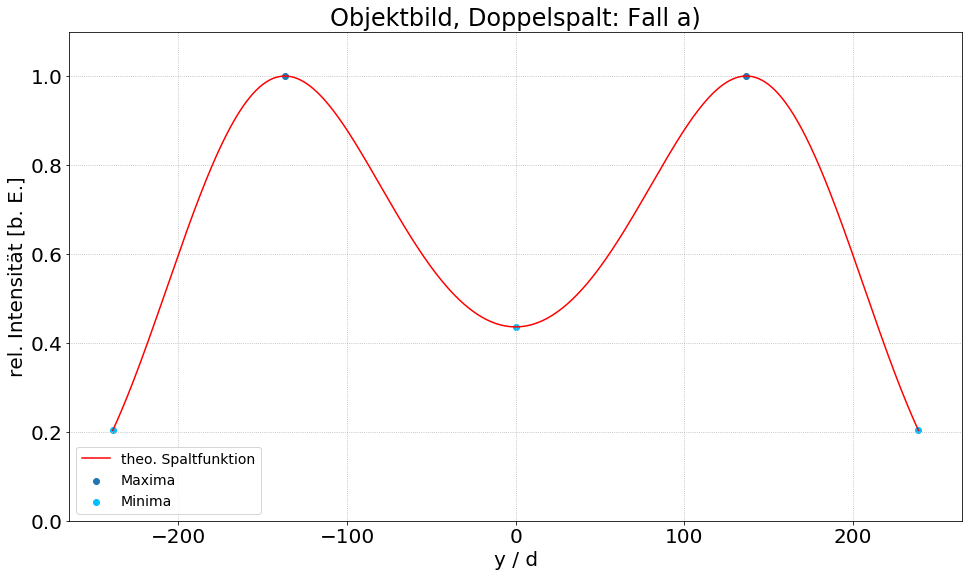

In [32]:
#Plot der bereits zuvor programmierten Doppelspaltfunktion mit passendem n.

maxPos_dspalt0, maxInt_dspalt0, minPos_dspalt0, minInt_dspalt0 = picture(doppelspalt, n_max_a, 'Objektbild, Doppelspalt: Fall a)')
plt.show()

### Fall b): iterative Bestimmung von k_y

In [33]:
#Spaltfunktion definieren
def doppelspalt(k):
    return d/np.pi*np.cos(k*g/2) *np.sin(k*d/2)/(k*d/2)*np.cos(y*k)

#Doppelspalt
d=1
g=prob_gd*d

In [34]:
x1 = [1,2]
k_y = 2*np.pi*1/g
Y = np.linspace(-d,d,501)
#k_y stets verkleinern und Maxima zählen. Wenn nur noch ein Maximum da ist, dann k_y ausgeben
while len(x1)>1:
    k_y=k_y-0.001
    f_modifiziert=[]
    for i in range(len(Y)):
        y=Y[i]
        result, error = quad(doppelspalt, 0, k_y)
        f_modifiziert.append(result**2)
    C =np.max(f_modifiziert)
    f_modifiziert/=C
    max_mask = np.r_[f_modifiziert[1:] < f_modifiziert[:-1], True] & np.r_[True,f_modifiziert[:-1] < f_modifiziert[1:]];
    x1=Y[np.where(max_mask)]
print(k_y)

1.6793790425728243


In [70]:
#numerisch berechnet, Berechung recht aufwendig bei gewählter Schrittweite
#bei anderen Werten einfach vorheriges Codefeld ausführen

#Vergleichswerte
k_y2=1.70
k_y3=1.78
k_y4=1.88

Y = np.linspace(-2,2,10001)*d

#für dieses k_y und zwei Vergleichswerte das Objektbild plotten
f_modifiziert=[]
for i in range(len(Y)):
    y=Y[i]
    result, error = quad(doppelspalt, 0, k_y)
    f_modifiziert.append(result**2)
C =np.max(f_modifiziert)
f_modifiziert/=C

f_modifiziert2=[]
for i in range(len(Y)):
    y=Y[i]
    result, error = quad(doppelspalt, 0, k_y2)
    f_modifiziert2.append(result**2)
C =np.max(f_modifiziert2)
f_modifiziert2/=C

f_modifiziert3=[]
for i in range(len(Y)):
    y=Y[i]
    result, error = quad(doppelspalt, 0, k_y3)
    f_modifiziert3.append(result**2)
C =np.max(f_modifiziert3)
f_modifiziert3/=C

f_modifiziert4=[]
for i in range(len(Y)):
    y=Y[i]
    result, error = quad(doppelspalt, 0, k_y4)
    f_modifiziert4.append(result**2)
C =np.max(f_modifiziert4)
f_modifiziert4/=C

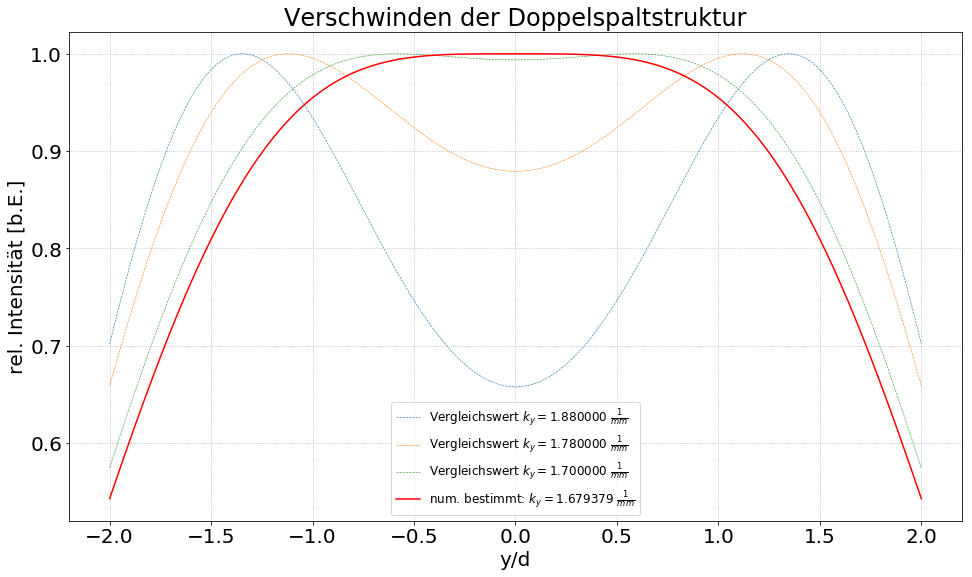

In [72]:
plt.plot(Y, f_modifiziert4,linestyle='--',linewidth=0.6,label=r'Vergleichswert $k_y=%f \ \frac{1}{mm}$'%k_y4)
plt.plot(Y, f_modifiziert3,linestyle='--',linewidth=0.6,label=r'Vergleichswert $k_y=%f \ \frac{1}{mm}$'%k_y3)
plt.plot(Y, f_modifiziert2,linestyle='--',linewidth=0.6,label=r'Vergleichswert $k_y=%f \ \frac{1}{mm}$'%k_y2)
plt.plot(Y, f_modifiziert,c='r',label=r'num. bestimmt: $k_y=%f \ \frac{1}{mm}$'%k_y)
plt.title('Verschwinden der Doppelspaltstruktur')
plt.grid(ls=':')
plt.xlabel('y/d')
plt.ylabel('rel. Intensität [b.E.]')
plt.legend(loc='best',fontsize=12)
plt.show()

In [73]:
ky_exp=np.pi*0.46e-3/(wavelength*f1)*1e-3
ky_exp_err=ky_exp*(0.04/0.46)

print('Das experimentelle Ergebnis berechnet sich zu:')
print('k_y = '+ form(ky_exp,ky_exp_err)+ ' 1/mm')

Das experimentelle Ergebnis berechnet sich zu:
k_y = 28.447 ± 2.474 1/mm


In [74]:
#für Fall b)
d_a=0.12e-3
d_a_err=0.04e-3

ky_theo_a = 2*np.pi*n_max_a/g
ky_theo_a_err = ky_theo_a *np.sqrt((n_max_a_err/n_max_a)**2+(prob_gd_err/g)**2)

ky_exp_a=np.pi*0.12e-3/(wavelength*f1)*1e-3
ky_exp_a_err=ky_exp_a*np.sqrt((0.04/0.12)**2)

print('Für den zweiten Fall erhalten wir:')
print('ky_theo = '+form(ky_theo_a,ky_theo_a_err))
print('ky_exp = '+form(ky_exp_a,ky_exp_a_err))

Für den zweiten Fall erhalten wir:
ky_theo = 1.007 ± 0.039
ky_exp = 7.421 ± 2.474
